
**Data source :** [Mobile price Dataset]( https://www.kaggle.com/iabhishekofficial/mobile-price-classification)



# Loading Laibrary

In [1]:
%%capture
!pip install category-encoders

# Standard Imports
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce

# Classifiers to Use
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Other needed imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/helah20/Dataset/main/train.csv')
dft=pd.read_csv('https://raw.githubusercontent.com/helah20/Dataset/main/test.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


# Scalling Data 

In [3]:
# Scale continuous features and replace in the original df
cols=['blue','dual_sim','four_g','three_g','touch_screen','wifi','price_range','n_cores']
scaler = StandardScaler() #  scalling only fore continuse feature , excloud boolean colums , n_cores one hot encoder
scaled_df = pd.DataFrame(scaler.fit_transform(df.drop(df[cols], axis=1)))


#  Modeling  :

#### define the Models  

In [4]:
# Create a dictionary holding all Classifiers and preprocessing techniques
models = {
    "rf": make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),RandomForestClassifier()),
    "knn": make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),KNeighborsClassifier()),
    "dt": make_pipeline(ce.OneHotEncoder(),SimpleImputer(strategy="median") ,DecisionTreeClassifier())
}

#### define cross validatition function to evaluate our models

In [5]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=9000)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

#### Split the data 

In [6]:
# Split data
X = df.drop("price_range", axis=1)
y = df["price_range"]

#### define the baseline model

In [7]:
# Baseline Score
print("Model Baseline")
df["price_range"].value_counts(normalize=True)[0]

Model Baseline


0.25

#### applying the models 

In [8]:
# Evaluate models on their own

result_ls = []
model_ls = []


# Iterate over models dict and evaluate each seprately
for key, value in models.items():

    # gather scores KFold cross validation scores
    score = evaluate_model(value, X, y)
    result_ls.append(score) # save results
    model_ls.append(key) # save model name
    print(f"Model: {key}, Score: {np.mean(score)}")

Model: rf, Score: 0.8772500000000001
Model: knn, Score: 0.92275
Model: dt, Score: 0.82875


#### comparing Models

Looking at our crossval score boxplots we can see that **KNN** models are performing pretty much **HIGHER**  than others.

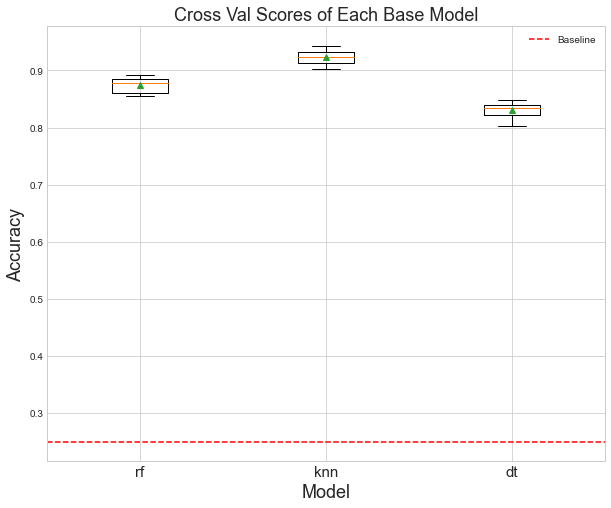

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(10,8))
plt.boxplot(result_ls, labels=model_ls, showmeans=True )
plt.title("Cross Val Scores of Each Base Model",fontsize=18)
plt.xlabel("Model",fontsize=18)
plt.xticks(fontsize=15)
plt.axhline(y=.25, linestyle="--", c="r", label="Baseline")
plt.legend()
plt.ylabel("Accuracy",fontsize=18);

 #### define stack moodel
 
to see if we can do better with [ model stacking ](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [ ]:
# Stacking Classifier is expecting a list
stack_ls = [
            ("rf", make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),RandomForestClassifier())), #  Random forest intead 
            ("knn", make_pipeline(ce.OneHotEncoder(), SimpleImputer(strategy="median"),KNeighborsClassifier())),
            ("dt", make_pipeline(ce.OneHotEncoder(),SimpleImputer(strategy="median") ,DecisionTreeClassifier()))
            ]

# Create Stacked Classifier
stack_model = StackingClassifier(stack_ls, cv=5)

# Add stack_model to models dictionary
models["stacked"] = stack_model

In [ ]:
# Evaluate All Models
result_ls = []
model_ls = []

# Iterate over models dict and evaluate each seprately
for key, value in models.items():

    # gather scores KFold cross validation scores
    score = evaluate_model(value, X, y)
    result_ls.append(score) # save results
    model_ls.append(key) # save model name
    print(f"Model: {key}, Score: {np.mean(score)}")

Model: rf, Score: 0.88325
Model: knn, Score: 0.92275
Model: dt, Score: 0.82725
Model: stacked, Score: 0.9265000000000001


#### comparing all Models

as we can see here our stacked estimator performed better than all base estimators so we will use the stacked estimator. 

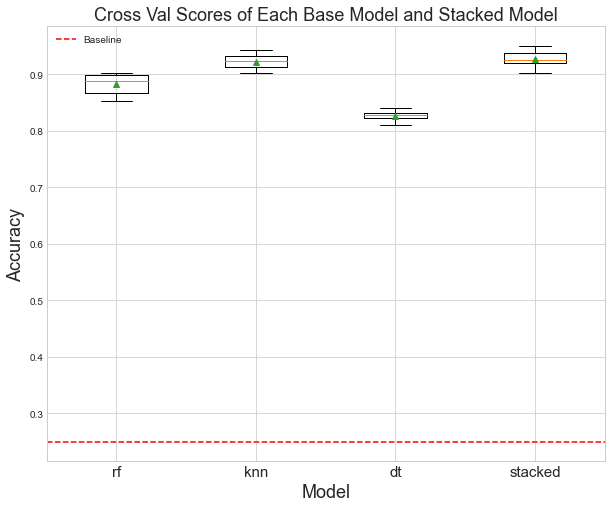

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(10,8))
plt.boxplot(result_ls, labels=model_ls, showmeans=True)
plt.xticks(fontsize=15)
plt.title("Cross Val Scores of Each Base Model and Stacked Model",fontsize=18)
plt.xlabel("Model",fontsize=18)
plt.axhline(0.25, linestyle="--", c="r", label="Baseline")
plt.legend()
plt.ylabel("Accuracy",fontsize=18);

# Optimizing stack model

 Now let's find the best pram using [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and fit our model

Grid Search

In [ ]:
param_grid = {
          
    "rf__randomforestclassifier__min_samples_leaf": [2,3],          
    "rf__randomforestclassifier__min_samples_split": [2, 3],  
    "rf__randomforestclassifier__n_estimators":[300,500],


    "dt__onehotencoder__drop_invariant": [True, False],
    "dt__simpleimputer__strategy": ["mean", "median"],
    
    "dt__decisiontreeclassifier__criterion": ["gini", "entropy"],
    "dt__decisiontreeclassifier__ccp_alpha": [0.0,0.030],

    "knn__kneighborsclassifier__n_neighbors": [5,7],
    "knn__kneighborsclassifier__metric": ["minkowski", "euclidean"],
}

grid_model = GridSearchCV(stack_model, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)
grid_model.fit(X,y)


In [ ]:
grid_model.best_score_

0.9289999999999999

In [ ]:
grid_model.best_params_

{'dt__decisiontreeclassifier__ccp_alpha': 0.0,
 'dt__decisiontreeclassifier__criterion': 'entropy',
 'dt__onehotencoder__drop_invariant': False,
 'dt__simpleimputer__strategy': 'median',
 'knn__kneighborsclassifier__metric': 'minkowski',
 'knn__kneighborsclassifier__n_neighbors': 7,
 'rf__randomforestclassifier__min_samples_leaf': 3,
 'rf__randomforestclassifier__min_samples_split': 2,
 'rf__randomforestclassifier__n_estimators': 500}

In [ ]:
# Pull out best model CV results to plot alongside all models tested
grid_df = pd.DataFrame(grid_model.cv_results_)
grid_cv_score_best = grid_df[grid_df["rank_test_score"]==1].loc[:,"split0_test_score":"split4_test_score"] .T[237].values

In [ ]:
grid_cv_score_best

array([0.9275, 0.9375, 0.9325, 0.93  , 0.9175])

In [ ]:
grid_df.values

array([[10.916251754760742, 0.17000802982458268, 0.09489946365356446,
        ..., 0.9205, 0.008124038404635969, 364],
       [17.407951068878173, 0.10157178127990739, 0.14479546546936034,
        ..., 0.9195, 0.007968688725254622, 431],
       [10.56116771697998, 0.14389258018040155, 0.09405035972595215, ...,
        0.9205, 0.008276472678623411, 364],
       ...,
       [16.345711946487427, 0.6362130335540983, 0.12485418319702149, ...,
        0.9285, 0.009823441352194245, 2],
       [9.38172287940979, 0.046673379565454594, 0.08244199752807617, ...,
        0.9265000000000001, 0.011575836902790225, 90],
       [14.931798553466797, 0.6684048999444825, 0.11358256340026855, ...,
        0.9259999999999999, 0.012308533625091198, 142]], dtype=object)

In [ ]:
# Add results to running list of other model scores
result_ls.append(grid_cv_score_best)
model_ls.append("grid")

In [ ]:
model_ls  # make sure that we have only one grid

['rf', 'knn', 'dt', 'stacked', 'grid']

In [ ]:
result_ls   # make sure we had one array for each model

[array([0.8825, 0.9   , 0.8625, 0.895 , 0.88  , 0.9   , 0.895 , 0.8525,
        0.8625, 0.9025]),
 array([0.9425, 0.9025, 0.9225, 0.925 , 0.9175, 0.93  , 0.94  , 0.9025,
        0.9125, 0.9325]),
 array([0.83  , 0.83  , 0.8225, 0.825 , 0.8225, 0.8375, 0.8325, 0.8225,
        0.81  , 0.84  ]),
 array([0.9425, 0.9075, 0.925 , 0.9225, 0.925 , 0.93  , 0.95  , 0.9025,
        0.92  , 0.94  ]),
 array([0.9275, 0.9375, 0.9325, 0.93  , 0.9175])]

<Figure size 432x288 with 0 Axes>

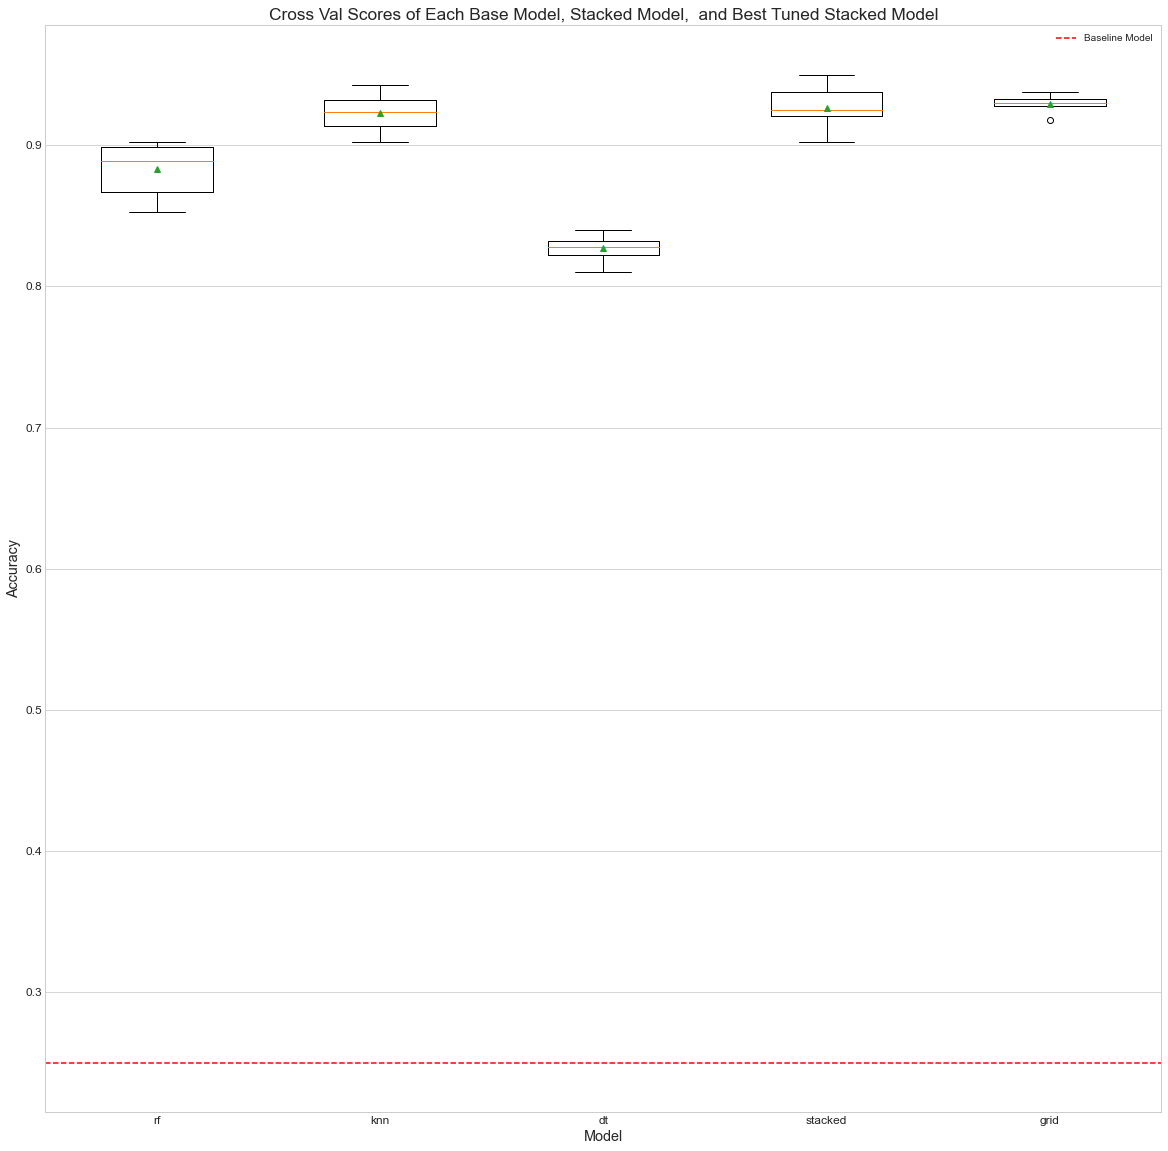

In [ ]:
# plot results
plt.style.use("seaborn-whitegrid")
plt.tight_layout()
plt.figure(figsize=(20,20))
plt.boxplot(result_ls, labels=model_ls, showmeans=True)
plt.title("Cross Val Scores of Each Base Model, Stacked Model,  and Best Tuned Stacked Model", fontsize="xx-large")
plt.xlabel("Model", fontsize="x-large")
plt.xticks(fontsize="large")
plt.yticks(fontsize="large")
plt.axhline(0.25, linestyle="--", c="r", label="Baseline Model")
plt.legend()
plt.ylabel("Accuracy", fontsize="x-large")
plt.grid(b=None, axis="x")
plt.savefig("compare_model.png", dpi=150);

#### split the data and apply the best model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

grid_model.fit(X_train, y_train).score(X_test, y_test)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 63.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 87.3min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed: 113.1min finished


0.94